# Nearest Neighbor Contrastive Explainer
- Nearest Neighbor Contrastive explanation method is an exemplar based constrastive explanation method which provides feasible or realizable contrastive instances. 
- For a given model, exemplar/representative dataset, and query point, it computes the closest point, within the representative dataset, that has a different prediction compared to the query point (with respect to the model). 
- The closeness is defined using an AutoEncoder and ensures a robust and faithful neighborhood even in case of high-dimensional feature space or noisy datasets. 
- This explanation method can also be used in the model-free case, where the model predictions are replaced by (user provided) ground truth. 

<a id='notebook_workflow'></a>
## Notebook Workflow
- [Imports](#imports)
- [Load Dataset](#load_dataset)
- [Train Classifier](#train_classifier)
- [Initialize NearestNeighborContrastiveExplainer Without Model](#initialize_explainer_model_free)
- [Model Free Explanation](#model_free_explanation)
- [Plot Model Free Explanations](#plot_model_free_explanations)
- [Initialize NearestNeighborContrastiveExplainer With Black Box Model](#initialize_black_box_model_explainer)
- [Black Box Model Explanation](#black_box_model_explanation)
- [Plot Black Box Model Explanations](#plot_black_box_model_explanations)

<a id='imports'></a>
### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from aix360.algorithms.nncontrastive import NearestNeighborContrastiveExplainer

# disable warnings 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
import tensorflow as tf

warnings.filterwarnings("ignore")

<a id='load_dataset'></a>
### Load Dataset
- This example notebook uses breast cancer dataset. The target label is 0 or 1. 0 indicates malignant and 1 indicates benign.
- It is important to normalize each feature such that they are in the range [0,1]

X Train and Test shapes
(512, 30) (57, 30)
 Mean(Y) , train, test
0.626953125 0.631578947368421


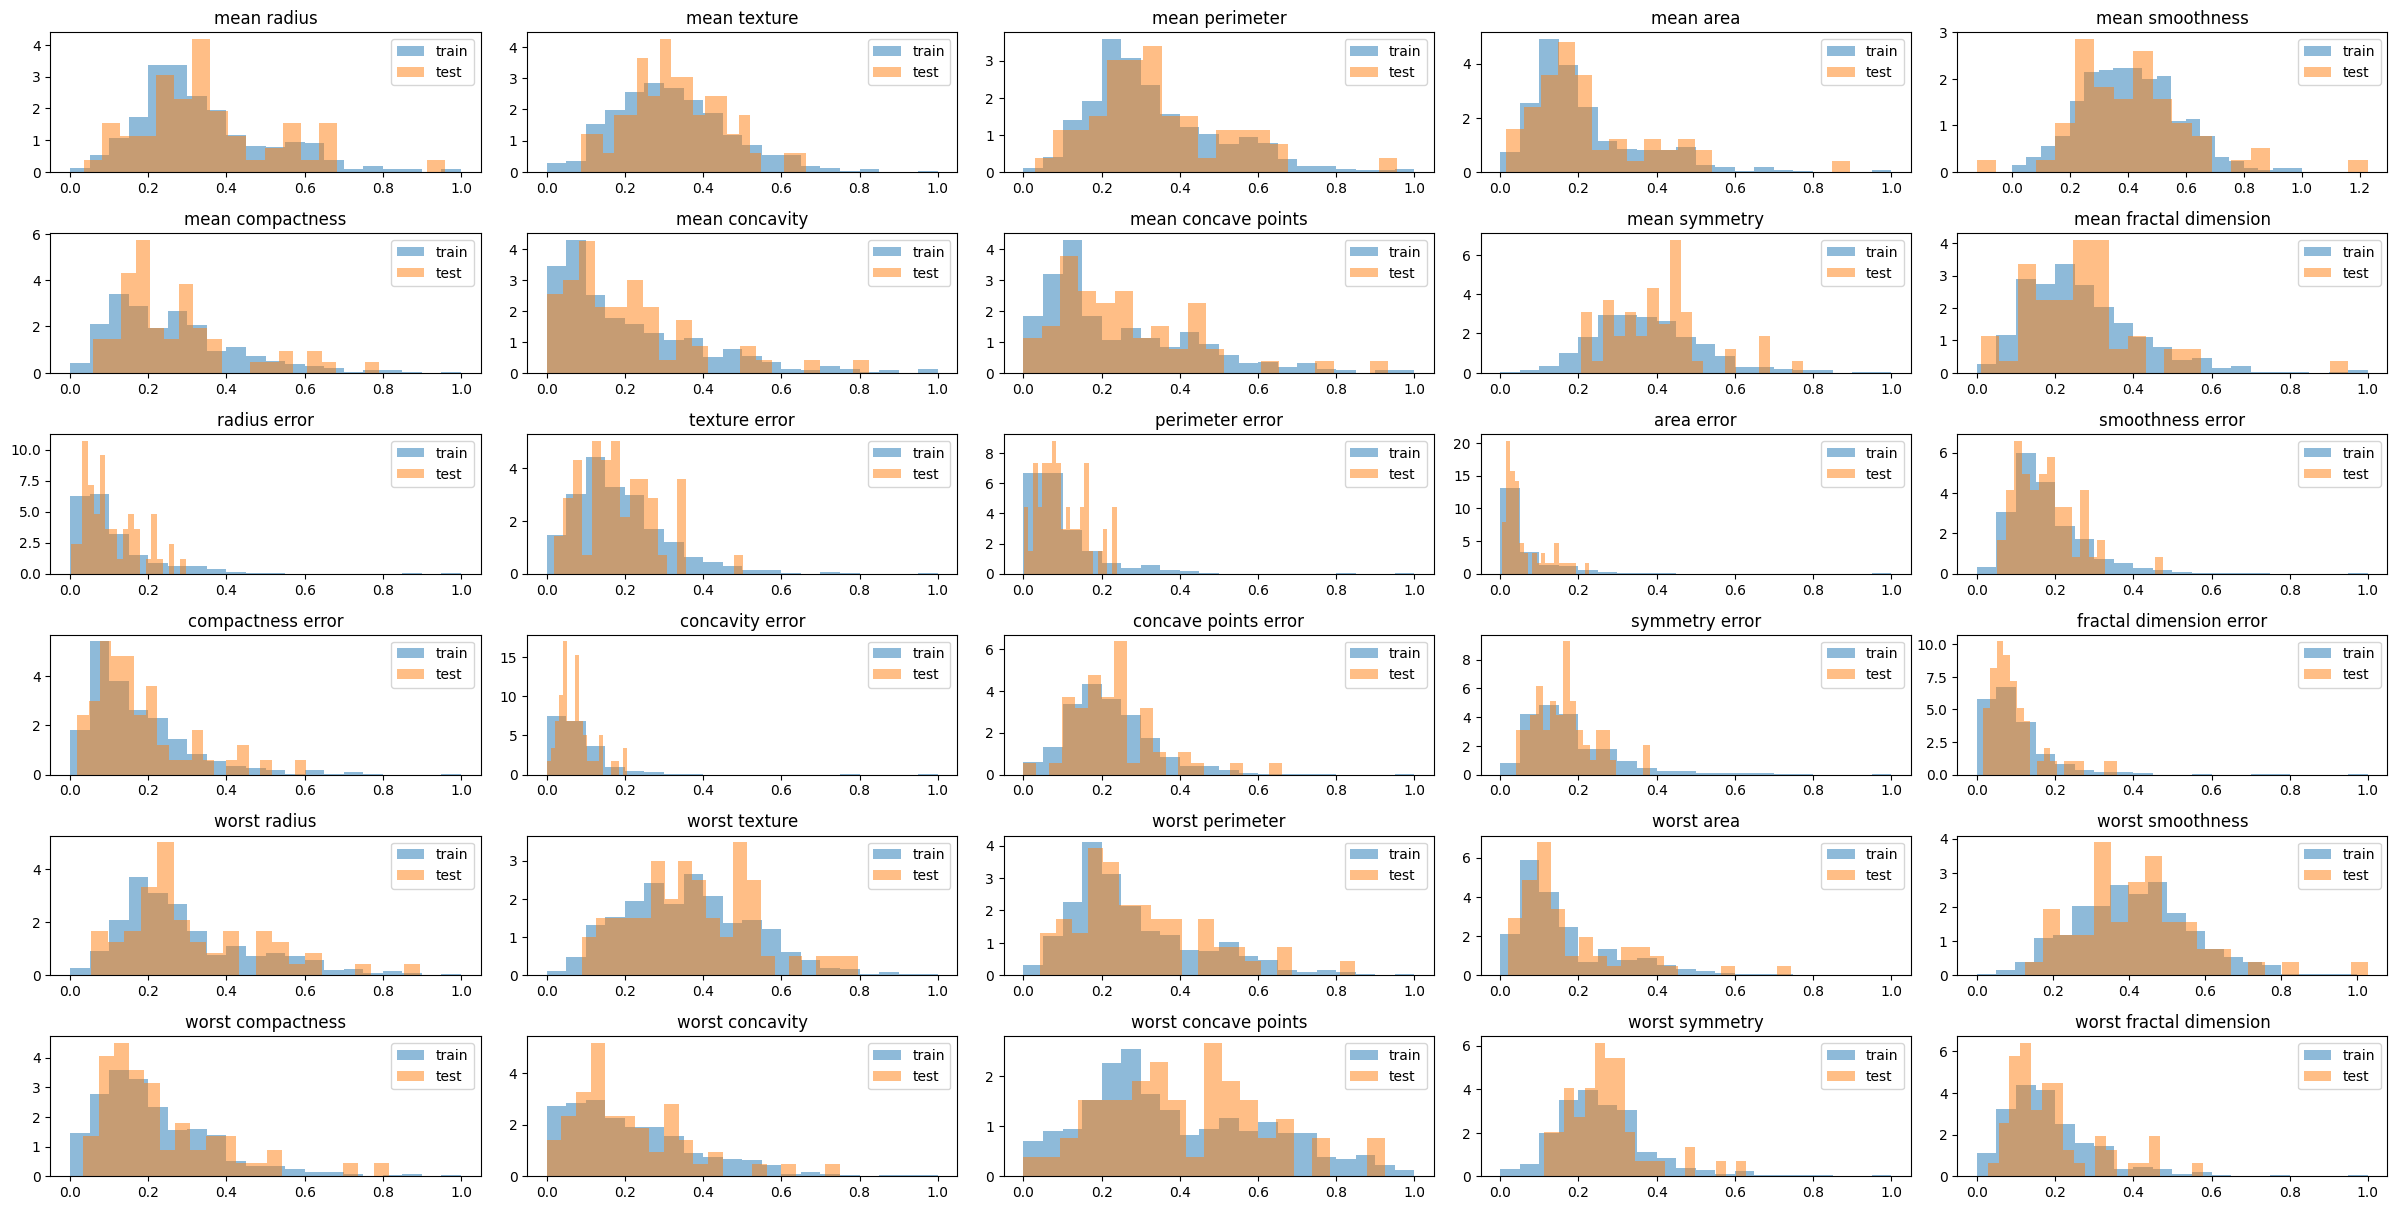

In [2]:
### Load Breast Cancer dataset example
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Loading data
dataset = load_breast_cancer()
X = dataset['data']
y = dataset['target']
target_names = dataset['target_names']
feature_names = dataset['feature_names']

xx_train, xx_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=42, stratify=y
        )

min_x = np.min(xx_train,axis = 0)
max_x = np.max(xx_train,axis = 0)

xx_train = (xx_train - min_x[np.newaxis, :]) / (
    max_x[np.newaxis, :] - min_x[np.newaxis, :]
)
xx_train = pd.DataFrame(xx_train, columns=feature_names)

xx_test = (xx_test - min_x[np.newaxis, :]) / (
    max_x[np.newaxis, :] - min_x[np.newaxis, :]
)
xx_test = pd.DataFrame(xx_test, columns=feature_names)

y_train_onehot = np.concatenate(
    [1 - y_train[:, np.newaxis], y_train[:, np.newaxis]], axis=1
).astype("float32")
y_test_onehot = np.concatenate(
    [1 - y_test[:, np.newaxis], y_test[:, np.newaxis]], axis=1
).astype("float32")

print('X Train and Test shapes')
print(xx_train.shape, xx_test.shape)
print(' Mean(Y) , train, test')
print(np.mean(y_train), np.mean(y_test))



plt.figure(figsize = (24,20))
for i in np.arange(xx_train.shape[1]):
    plt.subplot(10,5,i+1)
    plt.title(feature_names[i])
    plt.hist(xx_train.iloc[:,i],20, label = 'train',density = True,alpha = 0.5)
    plt.hist(xx_test.iloc[:,i],20, label = 'test',density = True,alpha = 0.5)
    plt.legend()
plt.tight_layout()
plt.show()

<a id='train_classifier'></a>
### Train Classifier

As an example we train a random forest model and use it 
- to select exemplars outside the explainer in case of model free.
- as a black box model to explain using the explainer.

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=2, random_state=10)

model.fit(xx_train, y_train)

y_train_pred = model.predict_proba(xx_train)
y_test_pred = model.predict_proba(xx_test)

print('Train accuracy ', np.mean(np.argmax(y_train_pred,axis = 1) == y_train))
print('Test accuracy ', np.mean(np.argmax(y_test_pred,axis = 1) == y_test))


Train accuracy  0.96484375
Test accuracy  0.8421052631578947


<a id='initialize_explainer_model_free'></a>
### Initialize NearestNeighborContrastiveExplainer Without Model [Model Free]

In this scenario, model is not used. User can select the exemplars to define the neighborhood space for the explainer.

In [4]:
epochs = 500
embedding_dim = 4
layers_config = []
random_seed = 1 # to have consistent resutls for demos
neighbors = 5 # number of explanations to be returned

explainer = NearestNeighborContrastiveExplainer(embedding_dim=embedding_dim, layers_config=layers_config, neighbors=neighbors)
benign_exemplars = xx_train.iloc[np.where(np.argmax(y_train_onehot,axis = 1) == 1)[0], :] ## Examples with pred target = 1
malignant_exemplars = xx_train.iloc[np.where(np.argmax(y_train_onehot,axis = 1) == 0)[0], :] ## Examples with pred target = 0

history = explainer.fit(
    xx_train,
    epochs=epochs,
    numeric_scaling=None,
    exemplars=benign_exemplars,
    random_seed=random_seed,
)

p_str = f'Epochs: {epochs}'
for key in history.history:
    p_str = f'{p_str}\t{key}: {history.history[key][-1]:.4f}'
print(p_str)

11/11 [==============================] - 0s 1ms/step
Epochs: 500	loss: 0.0040


In [5]:
explainer._embedding._encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Dense)     (None, 4)                 124       
                                                                 
Total params: 124
Trainable params: 124
Non-trainable params: 0
_________________________________________________________________


<a id='model_free_explanation'></a>
### Model Free Explanation: Find Nearest Cells

- Find nearest malignant cell for a selected cell.
- Find nearest Benign cell for a selected cell.

In [6]:
malignant_predictions_indices = np.where(np.argmax(y_test_pred,axis = 1) == 0)[0]
rand_index = np.random.choice(malignant_predictions_indices)
sample_malignant_cell = xx_test.iloc[rand_index:rand_index+1]
sample_malignant_cell

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
42,0.502579,0.460602,0.519729,0.355037,0.369631,0.555242,0.500469,0.498012,0.321212,0.499789,...,0.485237,0.449094,0.464117,0.307658,0.336412,0.437766,0.41254,0.685911,0.145082,0.441821


In [7]:
# compute nearest benign cell
nearest_benign_cell = explainer.explain_instance(sample_malignant_cell)
nearest_benign_cell[0]["neighbors"][0]

1/1 [==============================] - 0s 19ms/step


[0.3445028160348337,
 0.33615150490361845,
 0.3734365282288715,
 0.2063202545068929,
 0.19296751429614306,
 0.6254830991963684,
 0.7036082474226805,
 0.3875745526838966,
 0.32525252525252524,
 0.5840353833192923,
 0.09100126742712294,
 0.2496905940594059,
 0.12448758422466193,
 0.041927687439997904,
 0.12186830744127543,
 0.5423138162045243,
 0.36237373737373735,
 0.43417313885205533,
 0.250154781336185,
 0.41752000331661215,
 0.26218427605834227,
 0.3121002132196163,
 0.2818367448578117,
 0.12873574518285488,
 0.12443116212728383,
 0.3803300637424688,
 0.5417731629392971,
 0.5171821305841925,
 0.16420264143504834,
 0.3486816214088942]

In [8]:
# compute nearest malignant cell
explainer.set_exemplars(malignant_exemplars)
nearest_malignant_cell = explainer.explain_instance(sample_malignant_cell)
nearest_malignant_cell[0]["neighbors"][0]

1/1 [==============================] - 0s 19ms/step


[0.6204269014151167,
 0.4785255326344267,
 0.6282219611637067,
 0.46808059384941675,
 0.5534736585959363,
 0.5043248880436783,
 0.5349109653233365,
 0.6361829025844931,
 0.6005050505050504,
 0.5208508845829825,
 0.3478182147383668,
 0.30560466760961813,
 0.3320454224190737,
 0.23159966977837051,
 0.21249617568072884,
 0.3384804878781507,
 0.19315656565656567,
 0.3667361242659595,
 0.27407553329205825,
 0.17388720755082018,
 0.5602988260405549,
 0.4640191897654585,
 0.5398177200059765,
 0.37131340935902474,
 0.4315017319839705,
 0.30251962239621233,
 0.3939297124600639,
 0.6608247422680412,
 0.34082397003745324,
 0.2600682146136692]

<a id='plot_model_free_explanations'></a>
### Plot Model Free Explanations

In [9]:
def plot_matrix(matrix, vmin=None, vmax=None, precision=3, rotation=0):
    if len(matrix.shape) == 1:
        matrix = matrix[np.newaxis, :]

    if vmin is None:
        vmin = np.min(matrix)
    if vmax is None:
        vmax = np.max(matrix)

    fig, ax = plt.subplots(figsize=(20, 4))
    ax_mat = ax.matshow(matrix, vmin=vmin, vmax=vmax, aspect="auto", cmap="RdYlGn")
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            c = matrix[i, j]
            ax.text(
                j,
                i,
                str(np.round(c, precision)),
                va="center",
                ha="center",
                rotation=rotation,
                color="black",
                fontweight="bold",
                fontsize="x-large",
            )
    fig.colorbar(ax_mat, ax = ax)


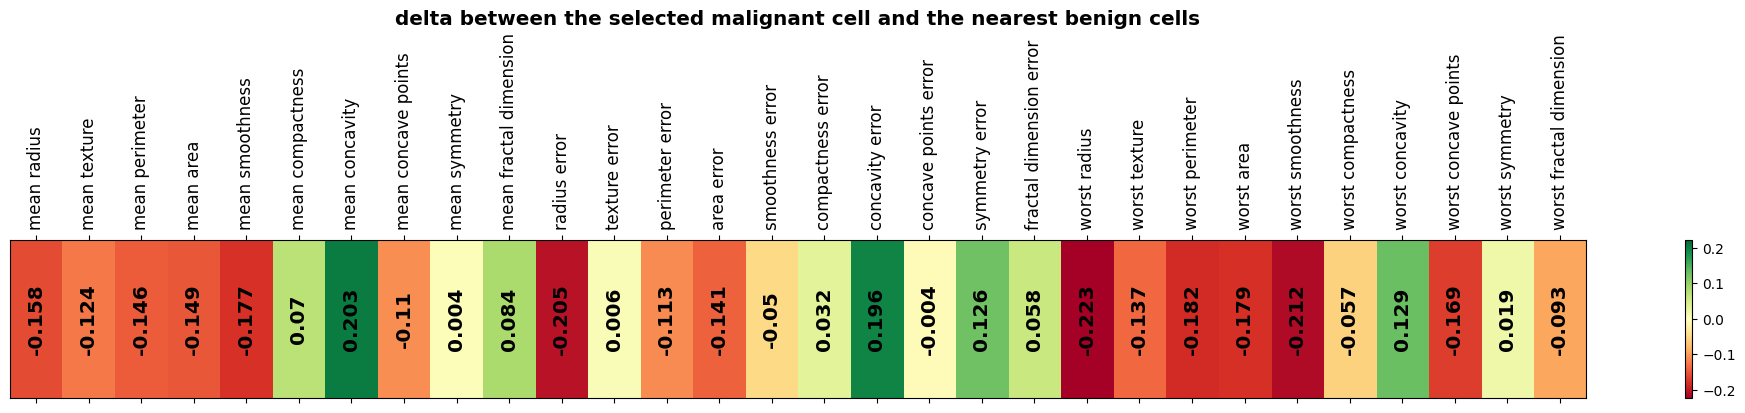

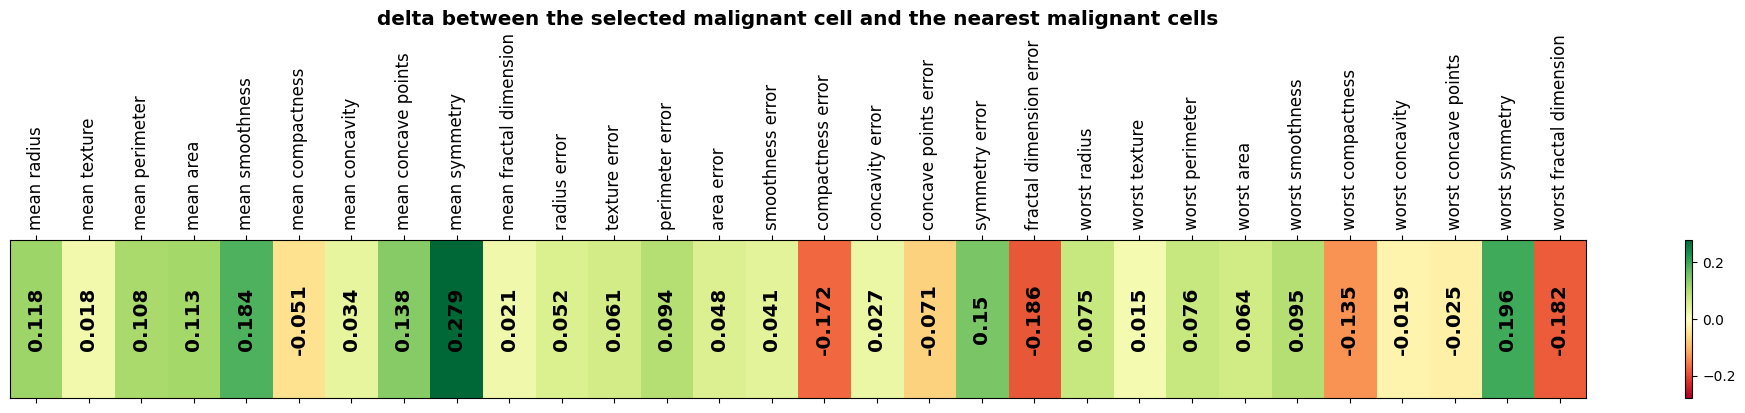

In [10]:
delta = np.array(nearest_benign_cell[0]["neighbors"][0]) - np.array(sample_malignant_cell)

plot_matrix(delta,vmin=-1*np.max(np.abs(delta)), vmax=np.max(np.abs(delta)), rotation = 90)
plt.xticks(np.arange(len(feature_names)), feature_names,rotation = 90, fontsize='large')
plt.yticks([])
plt.tight_layout()
plt.title('delta between the selected malignant cell and the nearest benign cells', fontsize='x-large', fontweight='bold')
plt.show()

delta = np.array(nearest_malignant_cell[0]["neighbors"][0]) - np.array(sample_malignant_cell)

plot_matrix(delta,vmin=-1*np.max(np.abs(delta)), vmax=np.max(np.abs(delta)), rotation = 90)
plt.xticks(np.arange(len(feature_names)), feature_names,rotation = 90, fontsize='large')
plt.yticks([])
plt.tight_layout()
plt.title('delta between the selected malignant cell and the nearest malignant cells', fontsize='x-large', fontweight='bold')
plt.show()


<a id='initialize_black_box_model_explainer'></a>
### Initialize NearestNeighborContrastiveExplainer With Black Box Model
Below cell initializes and fits the NearestNeighborContrastiveExplainer with trained black box model.

In [11]:
neighbors = 3
explainer_with_model = NearestNeighborContrastiveExplainer(model=model.predict,
                                              embedding_dim=embedding_dim,
                                              layers_config=layers_config,
                                              neighbors=neighbors)

history = explainer_with_model.fit(
    xx_train,
    epochs=epochs,
    numeric_scaling=None,
    random_seed=random_seed,
)

p_str = f'Epochs: {epochs}'
for key in history.history:
    p_str = f'{p_str}\t{key}: {history.history[key][-1]:.4f}'
print(p_str)

Epochs: 500	loss: 0.0040


<a id='black_box_model_explanation'></a>
### Black Box Model Explanation: Find Contrastive
Finds the nearest contrastive for a given cell.

In [12]:
# find nearest benign contrastive
nearest_benign_contrastive = explainer_with_model.explain_instance(sample_malignant_cell)
nearest_benign_contrastive[0]["neighbors"][0]

10/10 [==============================] - 0s 1ms/step


[0.36485399214349945,
 0.14440311126141359,
 0.3761315734918112,
 0.2174337221633086,
 0.49385570020683783,
 0.5037114287467027,
 0.3397375820056232,
 0.31312127236580517,
 0.5181818181818182,
 0.5075821398483572,
 0.1574144486692015,
 0.2543316831683168,
 0.1902652782358762,
 0.07965662927392332,
 0.28089200122378216,
 0.376933938174062,
 0.13328282828282828,
 0.2992991096798637,
 0.26239657792536725,
 0.157165954976991,
 0.3034507292778371,
 0.16844349680170578,
 0.31719707156730914,
 0.1533621706645694,
 0.4077294029749372,
 0.32619262450155717,
 0.25710862619808306,
 0.3807560137457045,
 0.24876798738419084,
 0.2429489702216975]

<a id='plot_black_box_model_explanations'></a>
### Plot Black Box Model Explanations

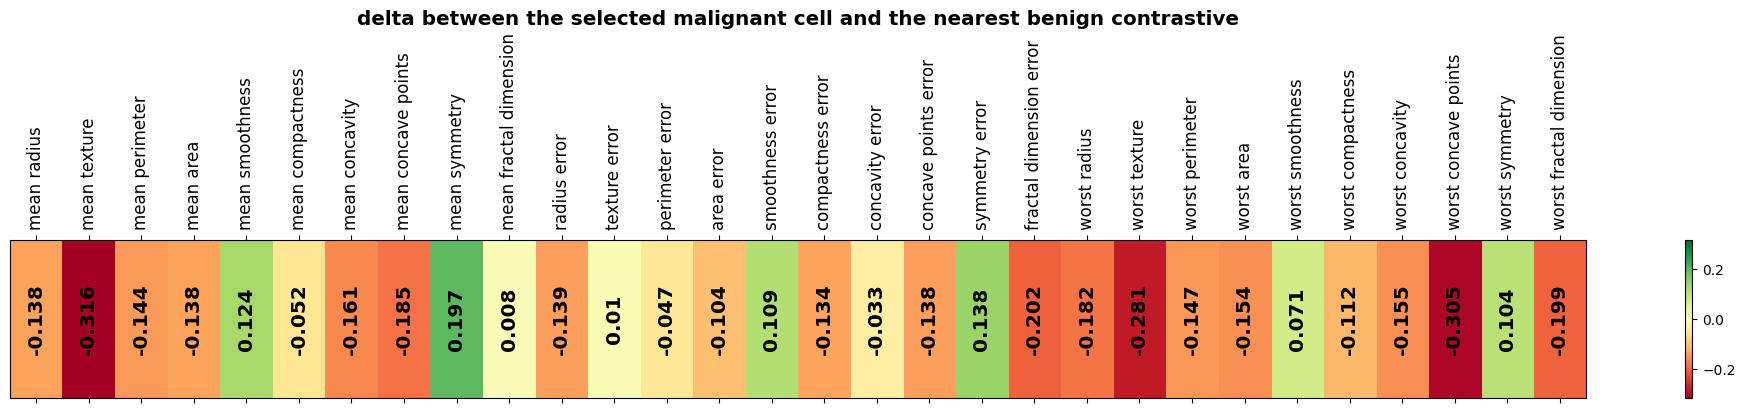

In [13]:
delta = np.array(nearest_benign_contrastive[0]["neighbors"][0]) - np.array(sample_malignant_cell)

plot_matrix(delta,vmin=-1*np.max(np.abs(delta)), vmax=np.max(np.abs(delta)), rotation = 90)
plt.xticks(np.arange(len(feature_names)), feature_names,rotation = 90, fontsize='large')
plt.yticks([])
plt.tight_layout()
plt.title('delta between the selected malignant cell and the nearest benign contrastive', fontsize='x-large', fontweight='bold')
plt.show()

In the above plot, the explanation generated using black box model NNExplainer can be different from the explanation generated using model free NNExplainer for the same input. The reason is that the model free NNExplainer uses exemplars selected using Ground Truth. Whereas the black box model NNExplainer uses exemplars filtered by model predictions. As model predictions may not match ground truth all the time, the internal algorithm may give different results for the same input.